In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

print(type(train_data))
X_train, y_train = train_data['features'],train_data['labels']
X_test, y_test = test_data['features'],test_data['labels']
X_val, y_val = val_data['features'],val_data['labels']

<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


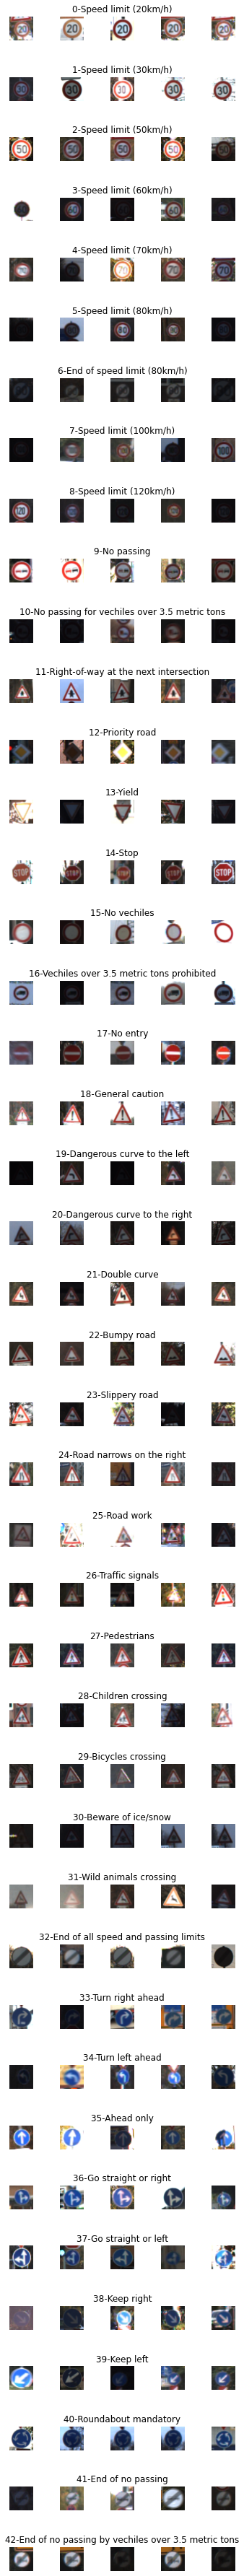

In [ ]:
data  = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []

cols=5
num_classes= 43

fig,axs = plt.subplots(nrows= num_classes,ncols= cols, figsize = (5,50))
fig.tight_layout()

for i in range(cols):
    for j,row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j)+"-"+row["SignName"])
        num_of_samples.append(len(x_selected))

(32, 32, 3)
36


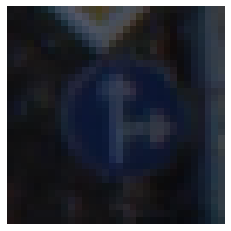

In [ ]:
import cv2
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])


(32, 32)


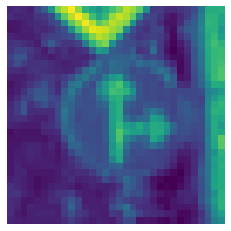

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


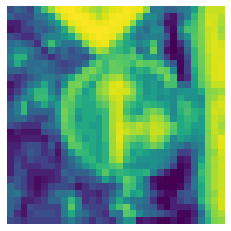

In [ ]:
def equalize(img):
 img =  cv2.equalizeHist(img)
 return img

img  = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)



(34799, 32, 32)


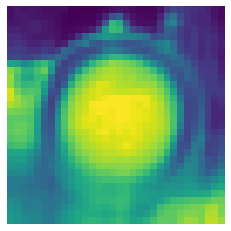

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img
  

X_train = np.array(list(map(preprocessing,X_train)))
X_test = np.array(list(map(preprocessing,X_test)))
X_val = np.array(list(map(preprocessing,X_val)))

plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val = X_val.reshape(4410, 32, 32,1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen =ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,shear_range=0.1,rotation_range=10)
datagen.fit(X_train)

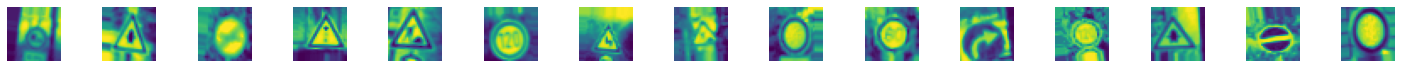

In [ ]:
batches = datagen.flow(X_train,y_train,batch_size=20)
X_batch ,y_batch = next(batches)

fig,axs = plt.subplots(1,15,figsize= (20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')



In [ ]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)

In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5), input_shape = (32,32,1), activation = 'relu'))
  model.add(Conv2D(60,(5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(15,(3,3),activation = 'relu'))
  model.add(Conv2D(30,(3,3),activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500,activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(lr=0.001),loss = 'categorical_crossentropy', metrics = ['accuracy']  )
  return model 





In [ ]:
 model = leNet_model()
 print(model.summary())
# history = model.fit(X_train,y_train,epochs =10 ,validation_data= (X_val,y_val),batch_size = 400,verbose =1, shuffle=1)
 history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch = 2000,epochs = 10, shuffle = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 15)        8115      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          4080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [ ]:
import requests 
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url,stream = True)
img = Image.open(r.raw)


Prediction is: [28]


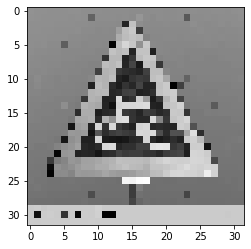

In [ ]:
import cv2
img_array = np.array(img)
resized = cv2.resize(img_array,(32,32))
gray_scale = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
image = cv2.bitwise_not(gray_scale)
plt.imshow(image,cmap=plt.get_cmap("gray"))
image = image/255
image = image.reshape(1,32,32,1)
prediction = model.predict_classes(image)
print('Prediction is:', str(prediction))